In [1]:
from dataset.semi_cv2 import SemiDataset
from model.semseg.deeplabv2 import DeepLabV2
from model.semseg.deeplabv3plus import DeepLabV3Plus
from model.semseg.pspnet import PSPNet
from utils.utils import count_params, MeanIOU, meanIOU, DiceCoefficient, color_map
from utils.DICELOSS import DiceLoss
from utils.loss_file import save_loss

In [2]:
import argparse
from copy import deepcopy
import numpy as np
import os
import json
from PIL import Image
import torch
from torch.nn import CrossEntropyLoss, DataParallel
from torch.optim import SGD
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn.functional as F

In [3]:
criterion = DiceLoss()

data_root = 'data/0_data_dataset_voc_950'
dataset = 'kidney'
pretrained_weights_path = 'outdir/models/kidney/1-3/re-training-2st_model_weight.pth'
crop_size = 224

with open('voc_mask_color_map.json', 'r') as file:
    JsonData = json.load(file)
voc_mask_color_map = JsonData['voc_mask_color_map']

In [4]:
valset = SemiDataset(dataset, data_root, 'val', crop_size, colormap=voc_mask_color_map)    
valloader = DataLoader(valset, batch_size=4, shuffle=True, pin_memory=True, num_workers=4, drop_last=True)

In [5]:
model = DeepLabV3Plus('resnet18', 2)
state_dict = torch.load(pretrained_weights_path)
model.load_state_dict(state_dict)
model = DataParallel(model).cuda()

In [6]:
def calculate_metrics_and_confusion_matrix(pred, target, threshold=0.5):
    target_one_hot = F.one_hot(target, num_classes=pred.shape[1]).permute(0, 3, 1, 2).float()
    target_one_hot = target_one_hot[:, 1:, :, :]

    pred = pred[:, 1:, :, :]
    pred = torch.sigmoid(pred)
    
    # Apply threshold to predictions
    pred_bin = (pred > threshold).float()
    
    TP = ((pred_bin == 1) & (target_one_hot == 1)).sum().item()
    FP = ((pred_bin == 1) & (target_one_hot == 0)).sum().item()
    FN = ((pred_bin == 0) & (target_one_hot == 1)).sum().item()
    TN = ((pred_bin == 0) & (target_one_hot == 0)).sum().item()
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    return sensitivity, specificity, TP, TN, FP, FN

In [7]:
model.eval()
tbar = tqdm(valloader)

model.eval()
total_v_loss = 0.0
total_sensitivity = 0.0
total_specificity = 0.0
metric_miou = MeanIOU()
metric_dice = DiceCoefficient()

with torch.no_grad():
    for img, mask in tbar:
        img = img.cuda()
        pred = model(img)
        mask = mask.cuda()  # 確保 mask 也在 GPU 上
        loss = criterion(pred, mask)
        sensitivity, specificity, TP, TN, FP, FN = calculate_metrics_and_confusion_matrix(pred, mask)
    
        avg_sensitivity = sensitivity
        avg_specificity = specificity

        total_v_loss += loss.item() 
           
        metric_miou.add_batch(pred, mask)
        metric_dice.add_batch(pred, mask)
        mIOU = metric_miou.evaluate()
        total_sensitivity += avg_sensitivity
        total_specificity += avg_specificity
        
        tbar.set_description('mIOU: %.2f' % (mIOU * 100.0))

mIOU: 31.84: 100%|██████████| 23/23 [00:01<00:00, 19.03it/s]


In [8]:
print('img shape: ', img.shape)
print('mask shape: ', mask.shape)
print('pred shape: ', pred.shape)

img shape:  torch.Size([4, 3, 224, 224])
mask shape:  torch.Size([4, 224, 224])
pred shape:  torch.Size([4, 2, 224, 224])


mIOU: 30.27:   0%|          | 0/23 [00:00<?, ?it/s]

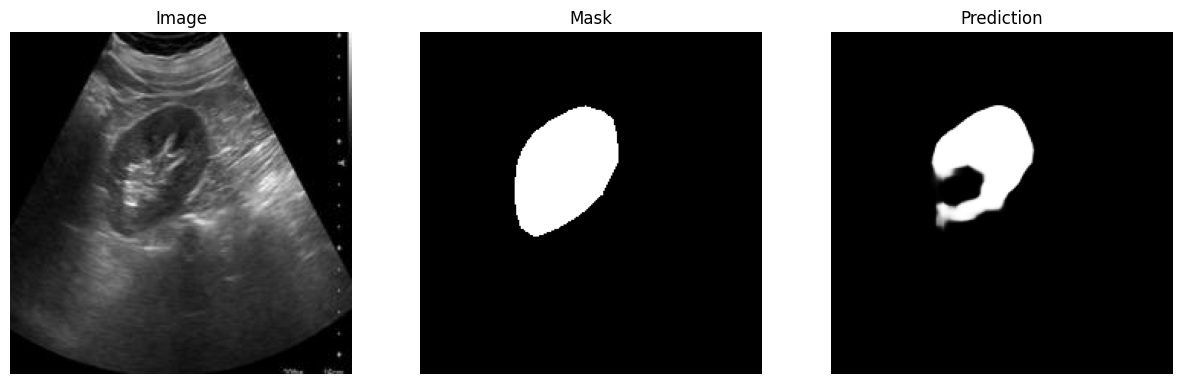

mIOU: 38.27:   4%|▍         | 1/23 [00:00<00:14,  1.54it/s]

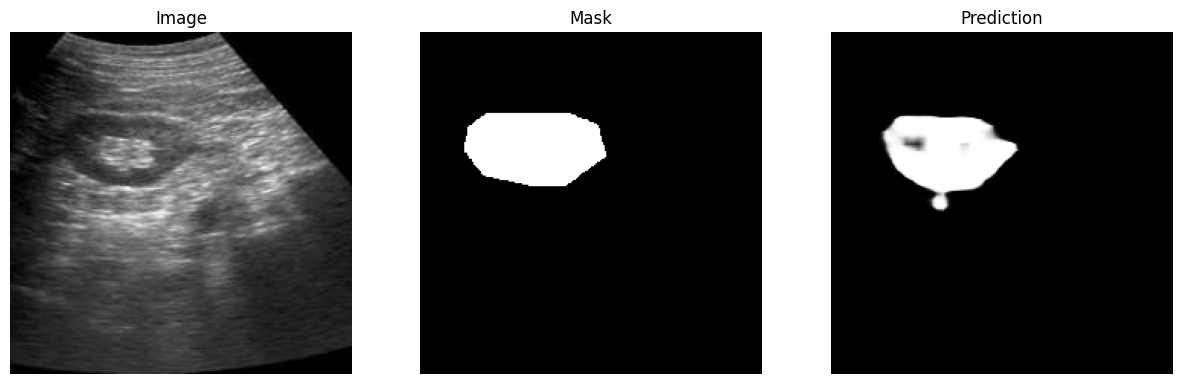

mIOU: 34.83:   9%|▊         | 2/23 [00:00<00:09,  2.18it/s]

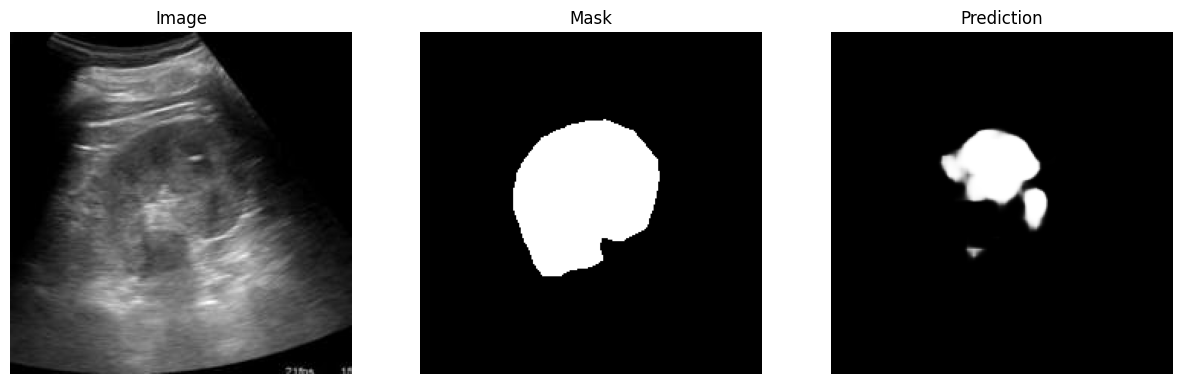

mIOU: 33.85:  13%|█▎        | 3/23 [00:01<00:07,  2.54it/s]

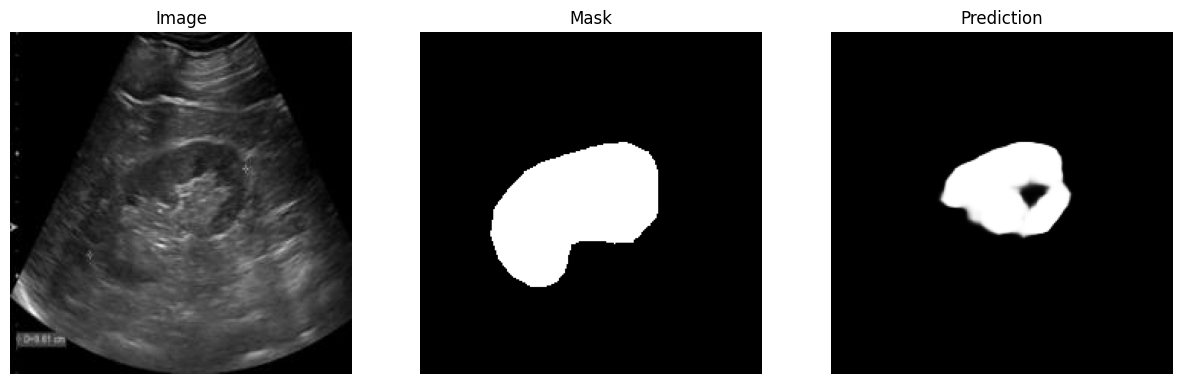

mIOU: 32.89:  17%|█▋        | 4/23 [00:01<00:06,  2.75it/s]

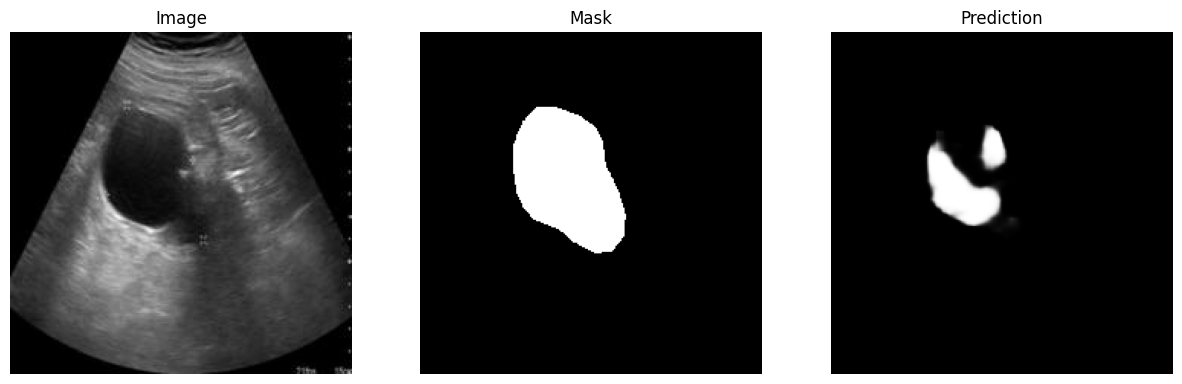

mIOU: 32.65:  22%|██▏       | 5/23 [00:01<00:06,  2.77it/s]

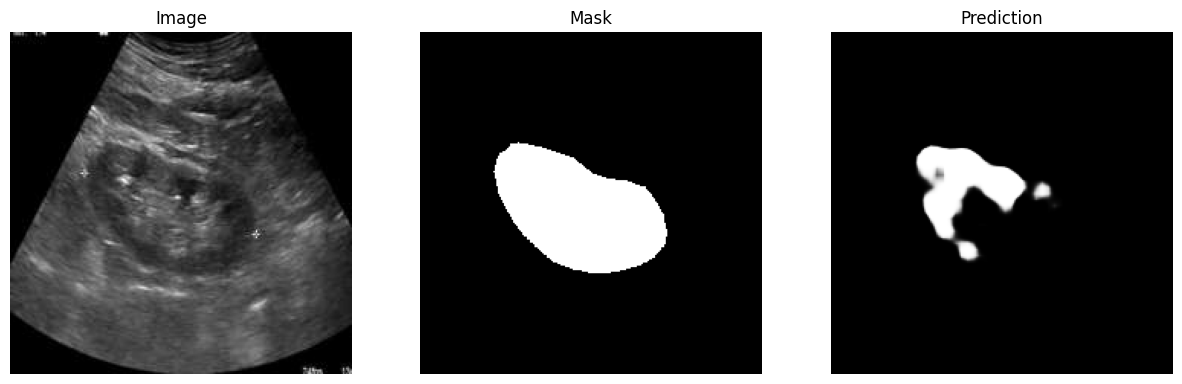

mIOU: 33.16:  26%|██▌       | 6/23 [00:02<00:06,  2.83it/s]

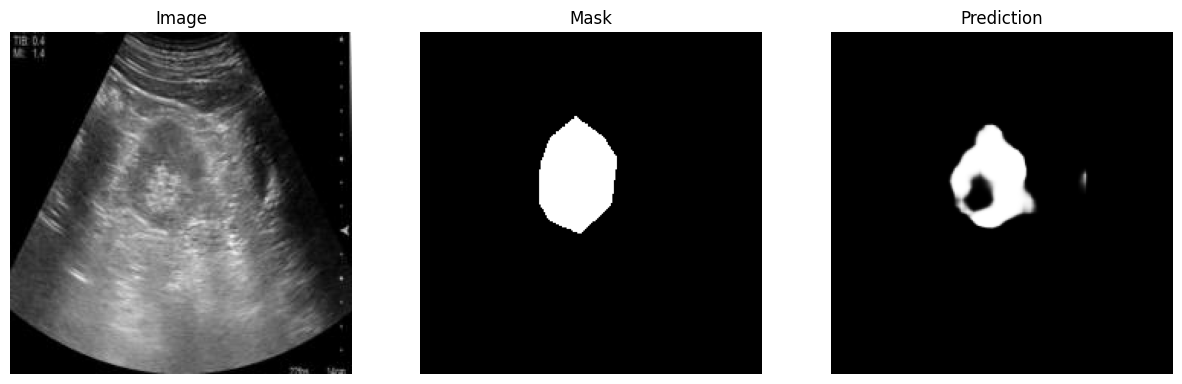

mIOU: 32.17:  30%|███       | 7/23 [00:02<00:05,  2.96it/s]

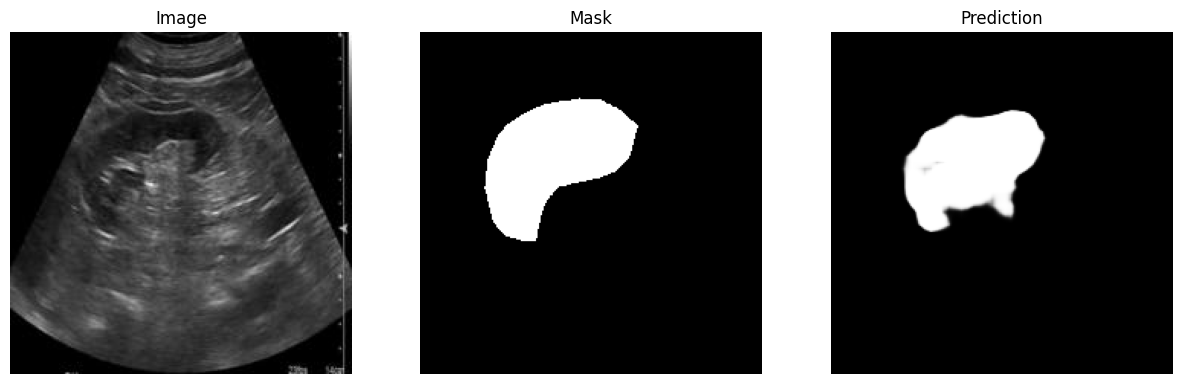

mIOU: 34.26:  35%|███▍      | 8/23 [00:02<00:04,  3.06it/s]

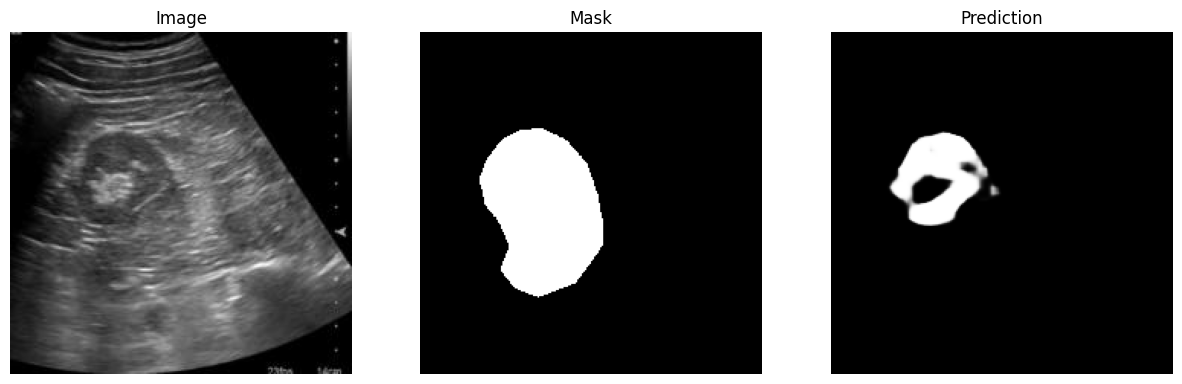

mIOU: 32.58:  39%|███▉      | 9/23 [00:03<00:04,  3.10it/s]

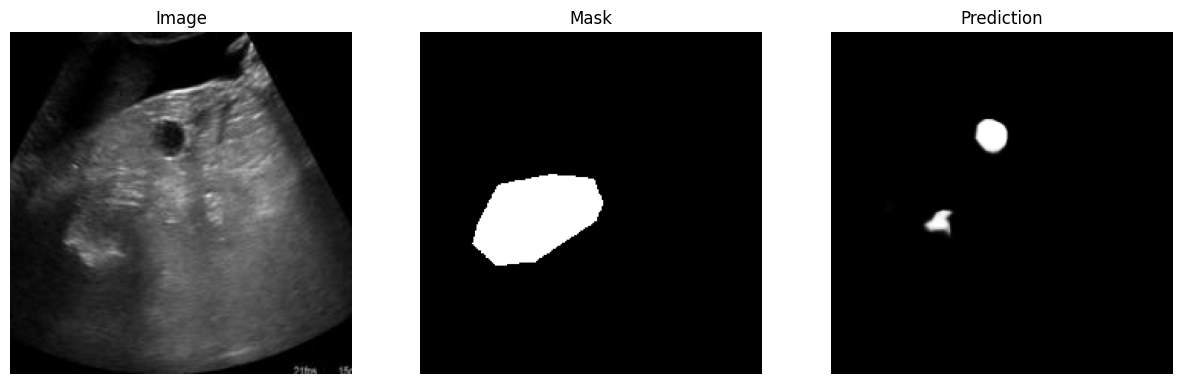

mIOU: 31.78:  43%|████▎     | 10/23 [00:03<00:03,  3.29it/s]

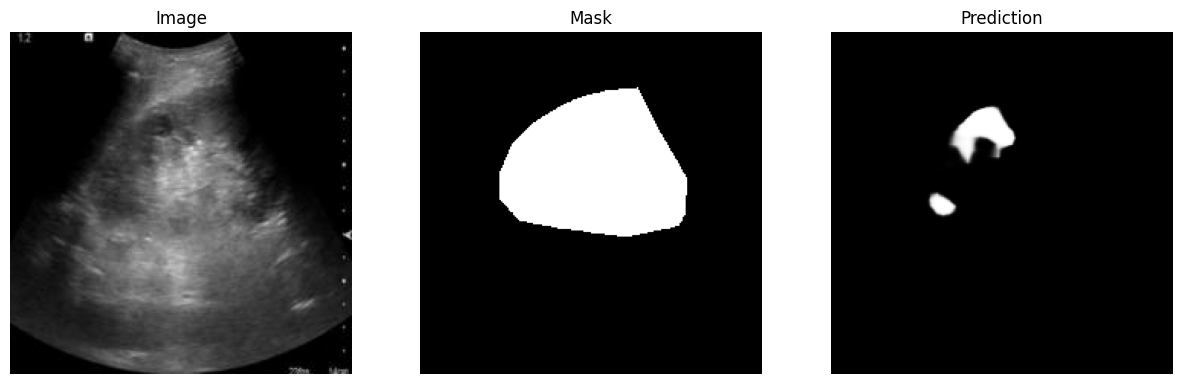

mIOU: 32.57:  48%|████▊     | 11/23 [00:03<00:03,  3.57it/s]

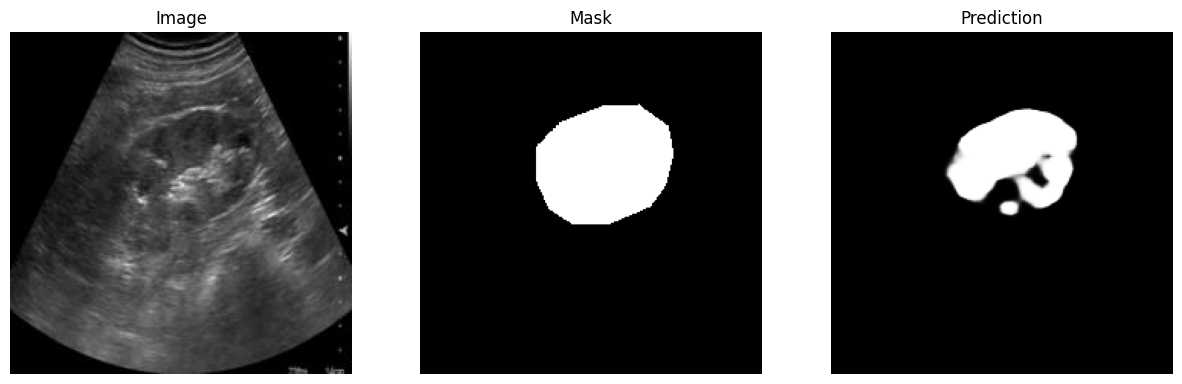

mIOU: 32.99:  52%|█████▏    | 12/23 [00:04<00:03,  3.05it/s]

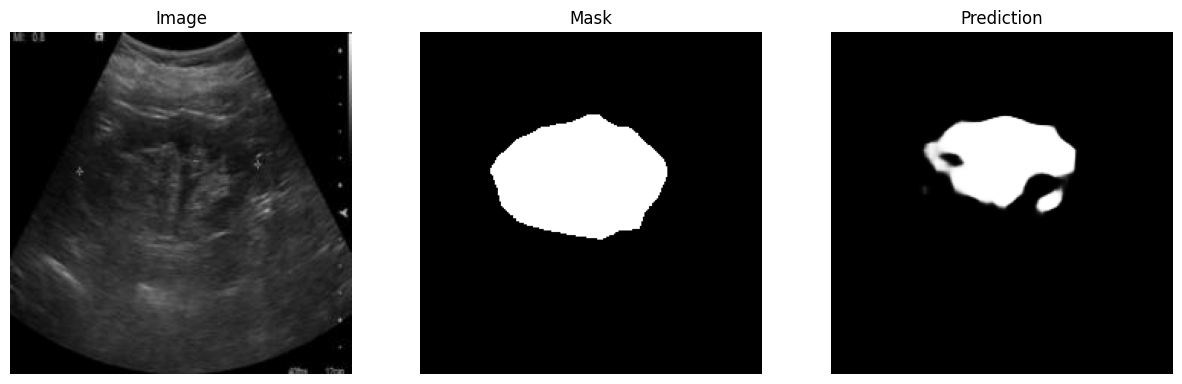

mIOU: 33.13:  57%|█████▋    | 13/23 [00:04<00:02,  3.35it/s]

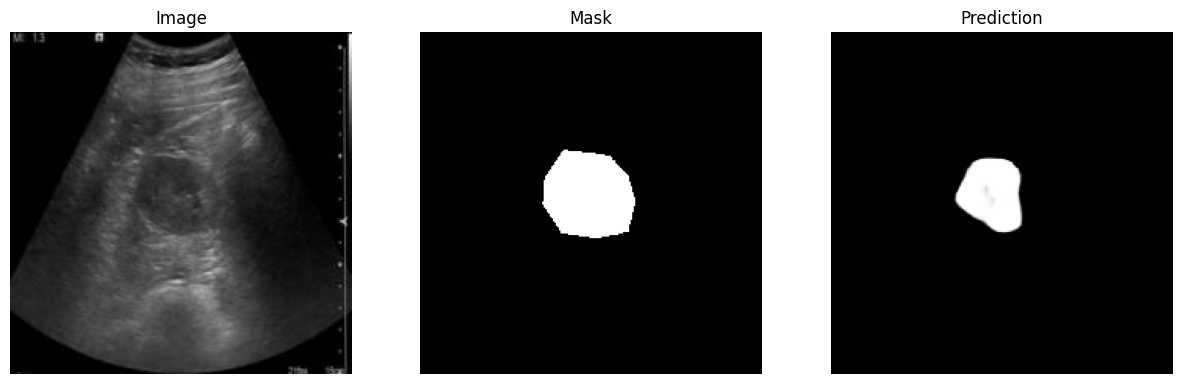

mIOU: 32.10:  61%|██████    | 14/23 [00:04<00:02,  3.64it/s]

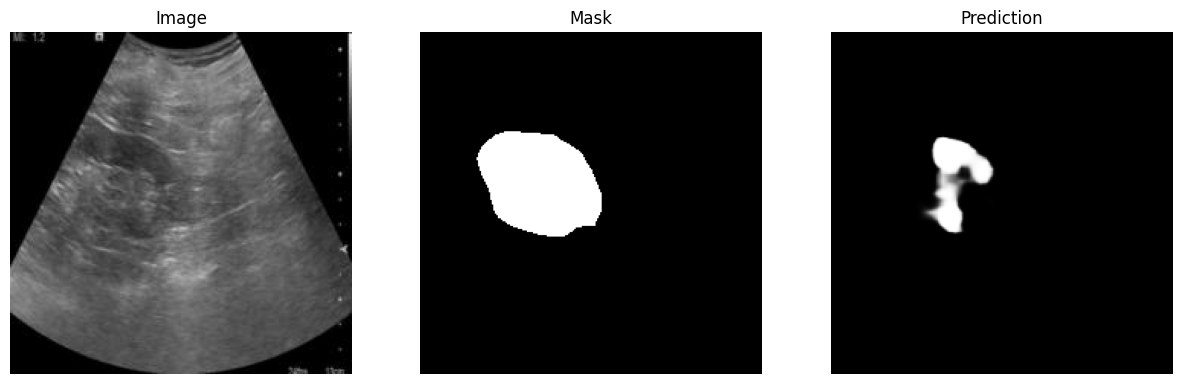

mIOU: 31.88:  65%|██████▌   | 15/23 [00:04<00:02,  3.87it/s]

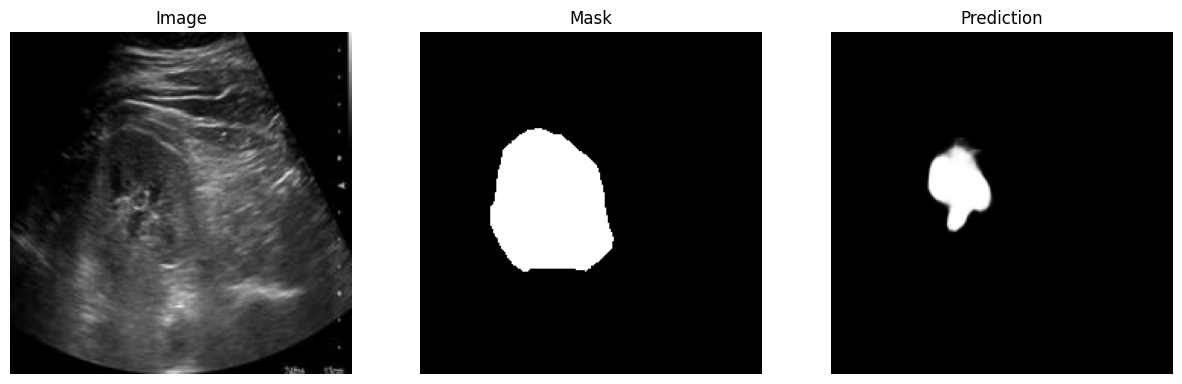

mIOU: 31.32:  70%|██████▉   | 16/23 [00:05<00:01,  4.05it/s]

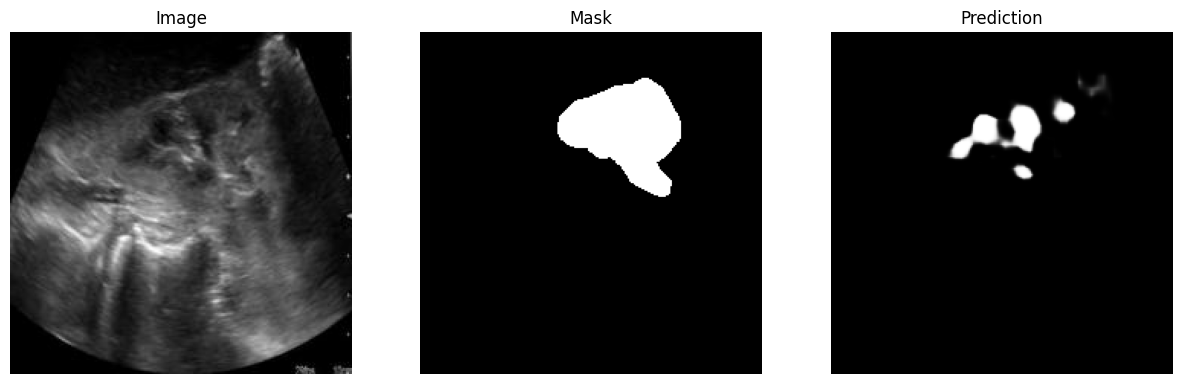

mIOU: 30.89:  74%|███████▍  | 17/23 [00:05<00:01,  4.23it/s]

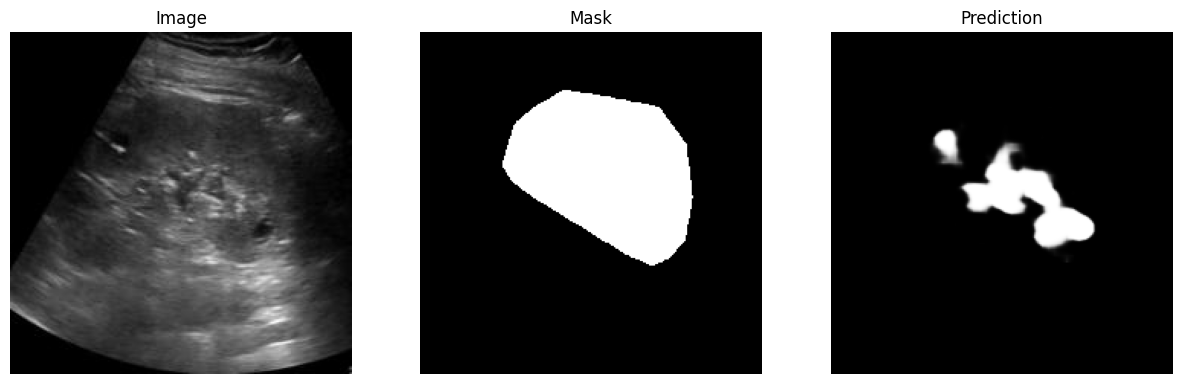

mIOU: 31.80:  78%|███████▊  | 18/23 [00:05<00:01,  4.30it/s]

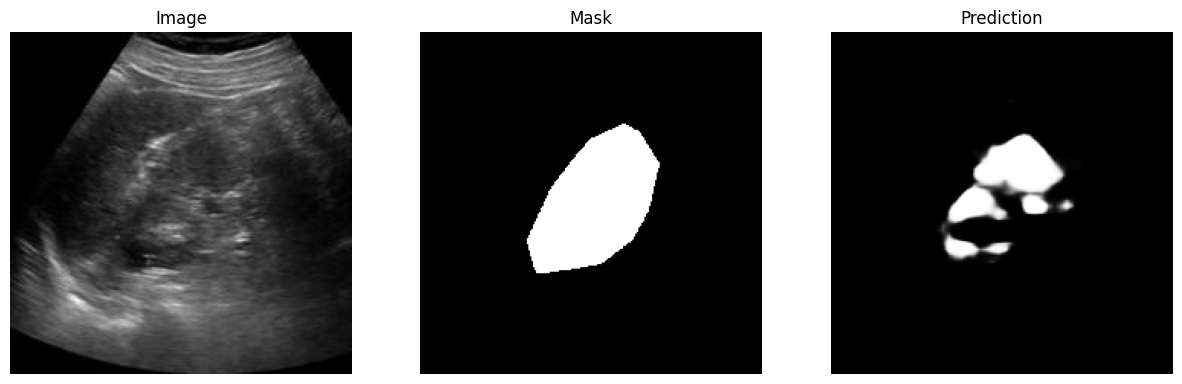

mIOU: 32.34:  83%|████████▎ | 19/23 [00:05<00:00,  4.39it/s]

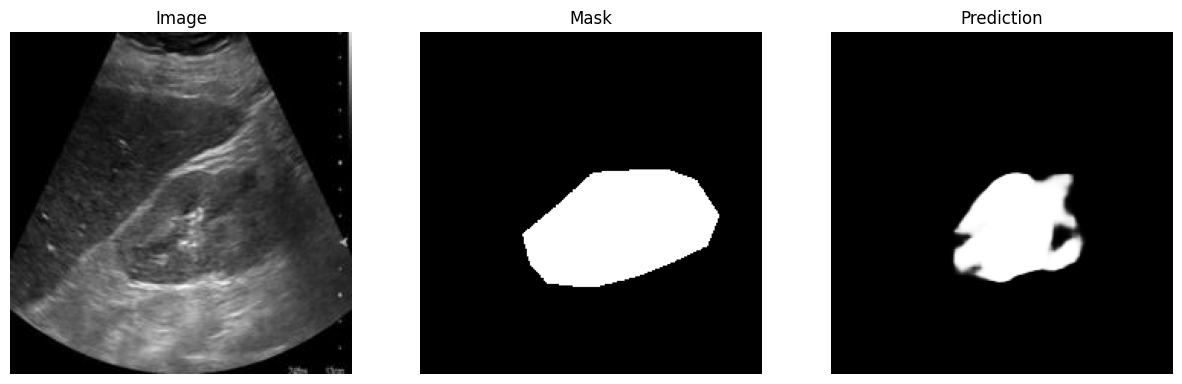

mIOU: 31.81:  87%|████████▋ | 20/23 [00:05<00:00,  4.45it/s]

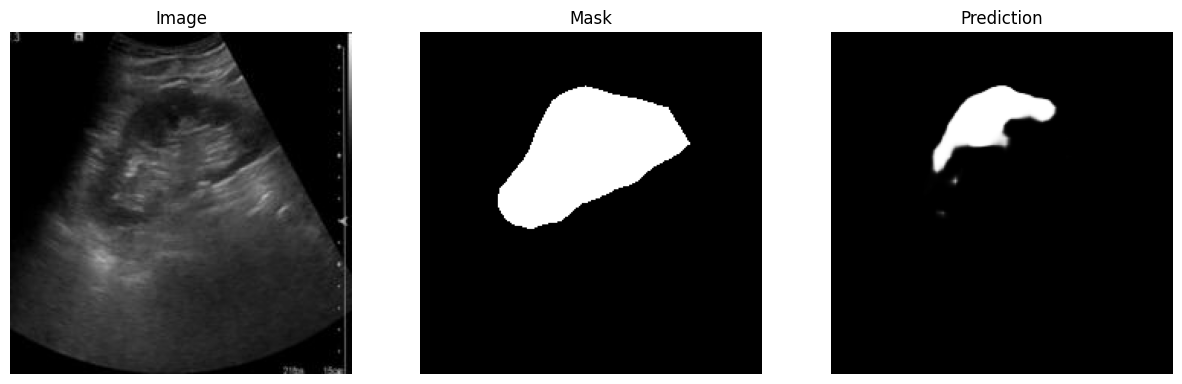

mIOU: 32.15:  91%|█████████▏| 21/23 [00:06<00:00,  4.52it/s]

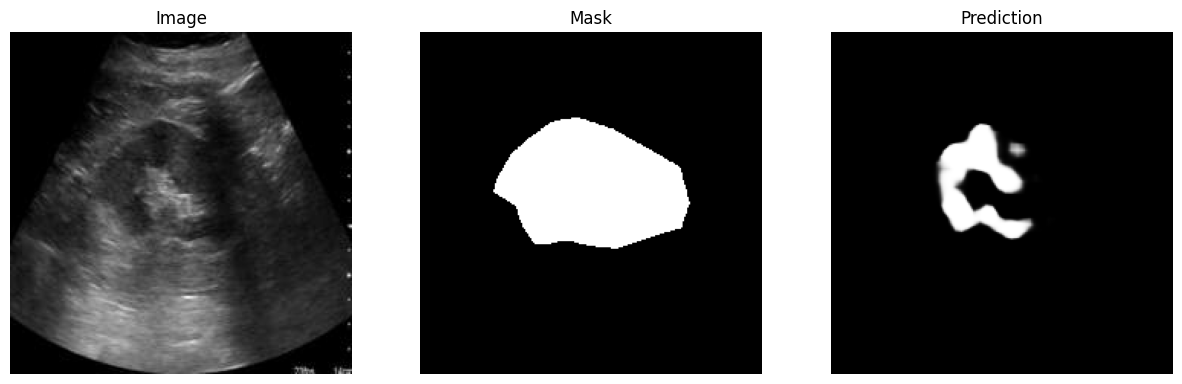

mIOU: 31.63:  96%|█████████▌| 22/23 [00:06<00:00,  4.57it/s]

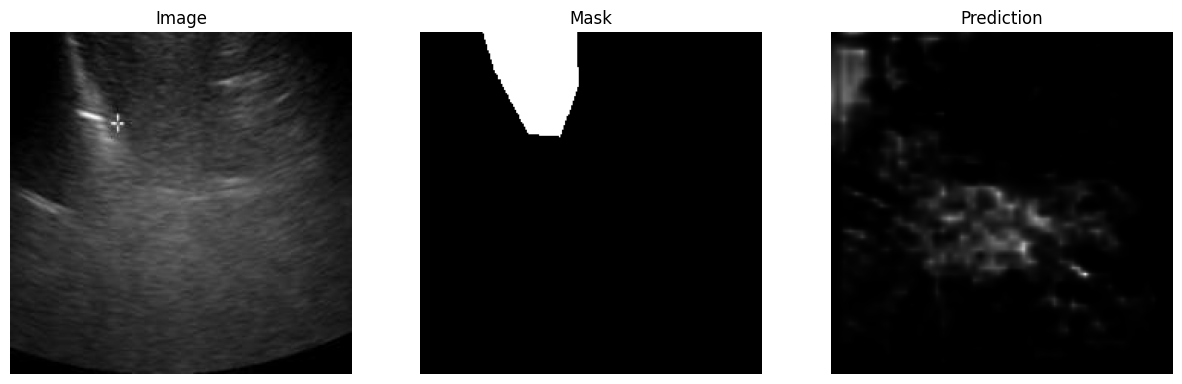

mIOU: 31.63: 100%|██████████| 23/23 [00:06<00:00,  3.48it/s]


In [9]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

model.eval()
tbar = tqdm(valloader)

model.eval()
total_v_loss = 0.0
metric_miou = MeanIOU()
metric_dice = DiceCoefficient()

with torch.no_grad():
    for img, mask in tbar:
        img = img.cuda()
        mask = mask.cuda()  # 確保 mask 也在 GPU 上

        pred = model(img)
        loss = criterion(pred, mask)

        total_v_loss += loss.item()

        metric_miou.add_batch(pred, mask)
        metric_dice.add_batch(pred, mask)
        mIOU = metric_miou.evaluate()
        tbar.set_description('mIOU: %.2f' % (mIOU * 100.0))

        # 可視化當前批次的預測
        img_np = img.cpu().numpy()
        
        # 只關注第1個通道的預測
        pred_np = F.sigmoid(pred)[:, 1, :, :].cpu().numpy()  # 取出第1個通道
        
        # 將 target 轉換為 one-hot 編碼並只取第1個通道
        target_one_hot = F.one_hot(mask, num_classes=pred.shape[1]).permute(0, 3, 1, 2).float()
        target_one_hot = target_one_hot[:, 1, :, :]  # 只取第1個通道
        mask_np = target_one_hot.cpu().numpy()

        # 正規化圖像數據
        img_np = (img_np - img_np.min(axis=(1, 2, 3), keepdims=True)) / (img_np.max(axis=(1, 2, 3), keepdims=True) - img_np.min(axis=(1, 2, 3), keepdims=True))

        for i in range(min(1, len(img_np))):  # 只可視化一張圖像
            img_i = np.transpose(img_np[i], (1, 2, 0))
            mask_i = mask_np[i]
            pred_i = pred_np[i]

            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
            axes[0].imshow(img_i)
            axes[0].set_title('Image')
            axes[0].axis('off')

            axes[1].imshow(mask_i, cmap='gray')
            axes[1].set_title('Mask')
            axes[1].axis('off')

            axes[2].imshow(pred_i, cmap='gray')  # 用灰度圖顯示
            axes[2].set_title('Prediction')
            axes[2].axis('off')

            plt.show()
            break  # 只顯示一張圖像，避免過多輸出

In [10]:
avg_test_loss = total_v_loss / len(valloader)
avg_train_miou = metric_miou.evaluate()
avg_train_dice = metric_dice.evaluate()


avg_sensitivity = total_sensitivity / len(valloader)
avg_specificity = total_specificity / len(valloader)

print(f"Avg Loss: {avg_test_loss}, Avg mIoU: {avg_train_miou}, Avg Dice: {avg_train_dice}, Avg Sensitivity: {avg_sensitivity}, Avg Specificity: {avg_specificity}")

Avg Loss: 0.5389183189557947, Avg mIoU: 0.31629353761672974, Avg Dice: 0.46108171343803406, Avg Sensitivity: 0.3161854745662041, Avg Specificity: 0.9981030059090397
